<a href="https://colab.research.google.com/github/root-epifit/madmo-adv/blob/my_exercise/homeworks/hw1_boosting_and_explanation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# ДЗ №1

# Homework 1
## Gradient boosting on temporal data and feature importances


Here we will work with widely known Human Actividy Recognition (HAR) dataset. Data is available at [UCI repository](https://archive.ics.uci.edu/ml/datasets/human+activity+recognition+using+smartphones).

There are available both raw and preprocessed datasets. This time we will use the preprocessed one.

Today we will work with [LightGBM](https://github.com/Microsoft/LightGBM) by Microsoft. It is one of the most popular frameworks these days that shows both great quality and performance.

There are another great frameworks (listed below). However, we will stick to `LightGBM` for this task.
* [Catboost](https://github.com/catboost/catboost) by Yandex. Novel framework by Yandex company tuned to deal well with categorical features.
* [xgboost](https://github.com/dmlc/xgboost) by dlmc. The most famous framework which got very popular on kaggle.

Some simple preprocessing is done for you. 

Your __ultimate target is to get familiar with one of the frameworks above__ and achieve at least 90% accuracy on test dataset and try to get some useful insights on the features the model paid attention to.

__Please, use [`shap`](https://github.com/slundberg/shap) and interpret the generated plots (with a brief summary).__

_Despite the main language of this notebook is English, feel free to write your thoughts in Russian._

## Part 0. Downloading and preprocessing

The preprocessing is done for you. Let's take a look at the data.

In [2]:
!wget -nc https://archive.ics.uci.edu/ml/machine-learning-databases/00240/UCI%20HAR%20Dataset.zip
!unzip -u "UCI HAR Dataset.zip" "UCI HAR Dataset/train/X_train.txt" "UCI HAR Dataset/train/y_train.txt"\
"UCI HAR Dataset/test/X_test.txt" "UCI HAR Dataset/test/y_test.txt" "UCI HAR Dataset/activity_labels.txt"

--2021-11-06 16:23:47--  https://archive.ics.uci.edu/ml/machine-learning-databases/00240/UCI%20HAR%20Dataset.zip
Resolving archive.ics.uci.edu (archive.ics.uci.edu)... 128.195.10.252
Connecting to archive.ics.uci.edu (archive.ics.uci.edu)|128.195.10.252|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 60999314 (58M) [application/x-httpd-php]
Saving to: ‘UCI HAR Dataset.zip’

UCI HAR Dataset.zip 100%[===================>]  58.17M  33.2MB/s    in 1.8s    

2021-11-06 16:23:49 (33.2 MB/s) - ‘UCI HAR Dataset.zip’ saved [60999314/60999314]

Archive:  UCI HAR Dataset.zip
  inflating: UCI HAR Dataset/activity_labels.txt  
  inflating: UCI HAR Dataset/test/y_test.txt  
  inflating: UCI HAR Dataset/train/X_train.txt  
caution: filename not matched:  UCI HAR Dataset/train/y_train.txtUCI HAR Dataset/test/X_test.txt


In [3]:
!unzip -u "UCI HAR Dataset.zip" "UCI HAR Dataset/train/X_train.txt" "UCI HAR Dataset/train/y_train.txt"

Archive:  UCI HAR Dataset.zip
  inflating: UCI HAR Dataset/train/y_train.txt  


In [4]:
!unzip -u "UCI HAR Dataset.zip" "UCI HAR Dataset/test/X_test.txt" "UCI HAR Dataset/test/y_test.txt" "UCI HAR Dataset/activity_labels.txt"

Archive:  UCI HAR Dataset.zip
  inflating: UCI HAR Dataset/test/X_test.txt  


###### Проверяем загрузки

In [5]:
! head -n 1 "UCI HAR Dataset/train/X_train.txt"

  2.8858451e-001 -2.0294171e-002 -1.3290514e-001 -9.9527860e-001 -9.8311061e-001 -9.1352645e-001 -9.9511208e-001 -9.8318457e-001 -9.2352702e-001 -9.3472378e-001 -5.6737807e-001 -7.4441253e-001  8.5294738e-001  6.8584458e-001  8.1426278e-001 -9.6552279e-001 -9.9994465e-001 -9.9986303e-001 -9.9461218e-001 -9.9423081e-001 -9.8761392e-001 -9.4321999e-001 -4.0774707e-001 -6.7933751e-001 -6.0212187e-001  9.2929351e-001 -8.5301114e-001  3.5990976e-001 -5.8526382e-002  2.5689154e-001 -2.2484763e-001  2.6410572e-001 -9.5245630e-002  2.7885143e-001 -4.6508457e-001  4.9193596e-001 -1.9088356e-001  3.7631389e-001  4.3512919e-001  6.6079033e-001  9.6339614e-001 -1.4083968e-001  1.1537494e-001 -9.8524969e-001 -9.8170843e-001 -8.7762497e-001 -9.8500137e-001 -9.8441622e-001 -8.9467735e-001  8.9205451e-001 -1.6126549e-001  1.2465977e-001  9.7743631e-001 -1.2321341e-001  5.6482734e-002 -3.7542596e-001  8.9946864e-001 -9.7090521e-001 -9.7551037e-001 -9.8432539e-001 -9.8884915e-001 -9.1774264e-001 -1.0000

In [6]:
! head -n 2 "UCI HAR Dataset/train/y_train.txt"

5
5


In [7]:
! head "UCI HAR Dataset/activity_labels.txt"

1 WALKING
2 WALKING_UPSTAIRS
3 WALKING_DOWNSTAIRS
4 SITTING
5 STANDING
6 LAYING


In [8]:
! rm unique_columns*
#! wget --no-check-certificate --content-disposition https://github.com/root-epifit/madmo-adv/blob/my_exercise/homeworks/unique_columns.txt
! curl -LJ0 https://raw.githubusercontent.com/root-epifit/madmo-adv/my_exercise/homeworks/unique_columns.txt > unique_columns.txt
print("File contents:")
! head -n 2 unique_columns.txt

rm: cannot remove 'unique_columns*': No such file or directory
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  2050  100  2050    0     0  15185      0 --:--:-- --:--:-- --:--:-- 15185
File contents:
0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125,126,127,128,129,130,131,132,133,134,135,136,137,138,139,140,141,142,143,144,145,146,147,148,149,150,151,152,153,154,155,156,157,158,159,160,161,162,163,164,165,166,167,168,169,170,171,172,173,174,175,176,177,178,179,180,181,182,183,184,185,186,187,188,189,190,191,192,193,194,195,196,197,198

In [9]:
import matplotlib.pyplot as plt
import numpy as np

In [10]:
X_train = np.genfromtxt("UCI HAR Dataset/train/X_train.txt")
y_train = np.genfromtxt("UCI HAR Dataset/train/y_train.txt")

X_test = np.genfromtxt("UCI HAR Dataset/test/X_test.txt")
y_test = np.genfromtxt("UCI HAR Dataset/test/y_test.txt")

activity_labels = {}
with open("UCI HAR Dataset/activity_labels.txt", "r") as file:
    for line in file:
        label, name = line.strip().split(" ")
        activity_labels[int(label)] = name

activity_labels

{1: 'WALKING',
 2: 'WALKING_UPSTAIRS',
 3: 'WALKING_DOWNSTAIRS',
 4: 'SITTING',
 5: 'STANDING',
 6: 'LAYING'}

In [11]:
X_train

array([[ 0.28858451, -0.02029417, -0.13290514, ..., -0.84124676,
         0.17994061, -0.05862692],
       [ 0.27841883, -0.01641057, -0.12352019, ..., -0.8447876 ,
         0.18028889, -0.05431672],
       [ 0.27965306, -0.01946716, -0.11346169, ..., -0.84893347,
         0.18063731, -0.04911782],
       ...,
       [ 0.27338737, -0.01701062, -0.04502183, ..., -0.77913261,
         0.24914484,  0.04081119],
       [ 0.28965416, -0.01884304, -0.15828059, ..., -0.78518142,
         0.24643223,  0.02533948],
       [ 0.35150347, -0.01242312, -0.20386717, ..., -0.78326693,
         0.24680852,  0.03669484]])

In [12]:
print(X_train.shape)
data_mean = X_train.mean(axis=0)
data_std = X_train.std(axis=0)

X_train = (X_train - data_mean) / data_std
X_test = (X_test - data_mean) / data_std

(7352, 561)


The dataset has some duplicating features. File `unique_columns.txt` stores the indices of the unique ones. 

In [13]:
unique_columns = np.genfromtxt("unique_columns.txt", delimiter=",").astype(int)
X_train_unique = X_train[:, unique_columns]
X_test_unique = X_test[:, unique_columns]

In [14]:
unique_columns.shape

(540,)

###### PCA could be useful in this case. E.g.

In [15]:
from sklearn.decomposition import PCA

In [16]:
pca = PCA(0.99)

In [17]:
X_train_pca = pca.fit_transform(X_train_unique)
X_test_pca = pca.transform(X_test_unique)

In [18]:
X_train_pca.shape

(7352, 179)

In [19]:
X_test_pca.shape

(2947, 179)

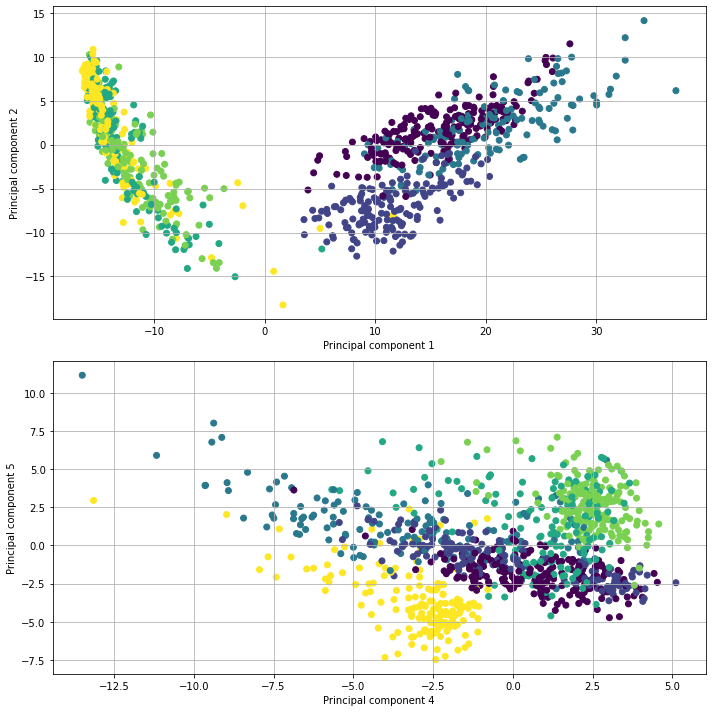

In [21]:
NUM_OBSERVATIONS = 1000

components = [[0,1],[3,4]]

fig, axs = plt.subplots(nrows=2, 
                        ncols=1, 
                        figsize=(10,10), 
                        #sharex='col', 
                        #sharey='row' ,
                        tight_layout=True
                        )


for i, item in enumerate(components):
    #axs[i].figure(figsize=(5,5))
    axs[i].scatter(X_train_pca[:NUM_OBSERVATIONS, item[0]], 
            X_train_pca[:NUM_OBSERVATIONS, item[1]], 
            c=y_train[:NUM_OBSERVATIONS],
             )
    axs[i].grid()
    axs[i].set_xlabel(f"Principal component {item[0]+1}")
    axs[i].set_ylabel(f"Principal component {item[1]+1}")
    

## Part 1. Fit the model.

Despite optimal parameters (e.g. for xgboost) can be found on the web, we still want you to approximate them by yourself.

In this part just check some hyperparams by hand.

In [99]:
# YOUR CODE HERE

# Example: https://rpubs.com/burakh/har_xgb

###### imports & defs

In [ ]:
! pip install shap

In [104]:
import lightgbm
from lightgbm import LGBMClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns 

import pandas as pd

from shap import TreeExplainer, summary_plot

lightgbm.__version__

def print_metrics(y_test:list, y_pred:list)-> list: 
    print("\nAccuracy:")
    for class_ in range(int(y_test.min()),int(y_test.max(6)+1)):
        acc = accuracy_score(y_test[np.where(y_test==class_)], 
                         y_pred[np.where(y_test==class_)])
        print(f'Class = {class_}, accuracy = {acc:.3}')
    
    total_acc = accuracy_score(y_test, y_pred)
    print(f'Overall accuracy = {total_acc:.3}\n\n')
    print(classification_report(y_test, y_pred))

    return rc

def get_metrics(y_test:list, y_pred:list)-> list: 
    rc = []
    for class_ in range(int(y_test.min()),int(y_test.max(6)+1)):
        acc = accuracy_score(y_test[np.where(y_test==class_)], 
                         y_pred[np.where(y_test==class_)])
        rc.append(acc)

    total_acc = accuracy_score(y_test, y_pred)
    rc.append(total_acc)

    return rc

###### Baseline

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
               importance_type='split', learning_rate=0.1, max_depth=-1,
               min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
               n_estimators=100, n_jobs=-1, num_leaves=31, objective=None,
               random_state=None, reg_alpha=0.0, reg_lambda=0.0, silent=True,
               subsample=1.0, subsample_for_bin=200000, subsample_freq=0)
[[482   0  14   0   0   0]
 [ 21 443   7   0   0   0]
 [ 57  47 316   0   0   0]
 [  0   1   0 417  71   2]
 [  0   0   0  30 502   0]
 [  0   0   0  23   1 513]]

Accuracy:


AxisError: ignored

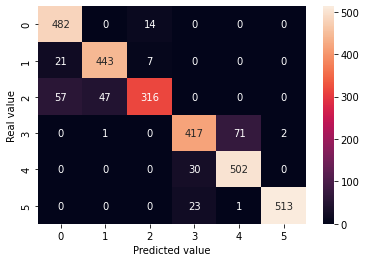

In [105]:
model = LGBMClassifier()
model.fit(X_train_pca, y_train)

y_pred = model.predict(X_test_pca)

# параметры модели по дефолту
print(model)

# Confusion matrix
cf_m = confusion_matrix(y_test, y_pred)
print(cf_m)
sns.heatmap(cf_m, annot=True, fmt="d")
plt.ylabel("Real value")
plt.xlabel("Predicted value")

# метрики
print_metrics(y_test, y_pred)

###### Feature importance (with shap)

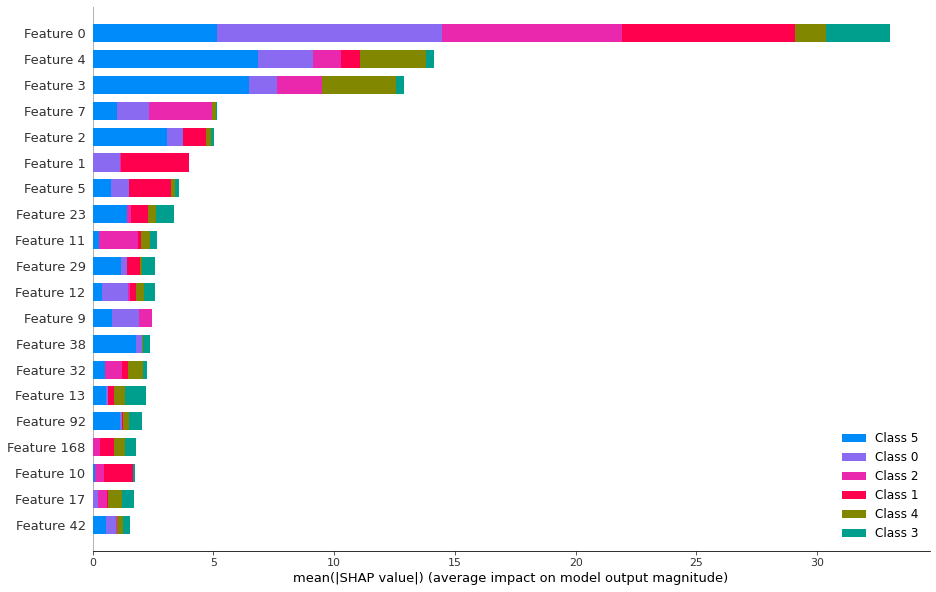

In [97]:
explainer = TreeExplainer(model)
shap_values = explainer.shap_values(X_test_pca) ###
summary_plot(shap_values, X_test_pca, plot_type="bar", plot_size=(15, 10)) ###

###### Manual parameters

------------------------
n_estimators=50
LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
               importance_type='split', learning_rate=1.0, max_depth=1,
               min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
               n_estimators=50, n_jobs=-1, num_leaves=31, objective=None,
               random_state=None, reg_alpha=0.0, reg_lambda=0.0, silent=True,
               subsample=1.0, subsample_for_bin=200000, subsample_freq=0,
               warm_start=True)
------------------------
n_estimators=100
LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
               importance_type='split', learning_rate=1.0, max_depth=1,
               min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
               n_estimators=100, n_jobs=-1, num_leaves=31, objective=None,
               random_state=None, reg_alpha=0.0, reg_lambda=0.0, silent=True,
               subsample=1.0, subsample_for_

Text(0, 0.5, 'accuracy')

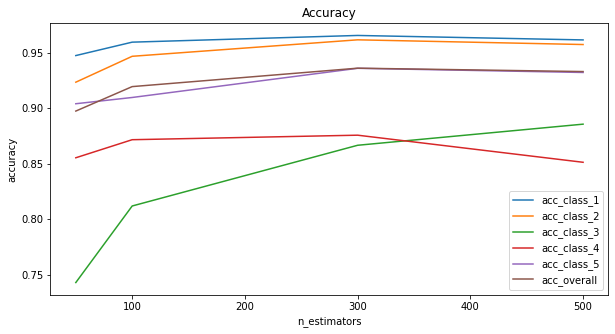

In [90]:
estimators = [50, 100, 300, 500]

model = LGBMClassifier(max_depth=1, 
                       learning_rate=1.0, 
                       warm_start=True)
results = []

for n_estimator in estimators:
    print("------------------------")
    print(f"n_estimators={n_estimator}")
    model.n_estimators=n_estimator
    print(model)
    model.fit(X_train_pca, y_train)
    y_pred = model.predict(X_test_pca)
    results.append(get_metrics(y_test, y_pred))

# Визуализируем
results = np.array(results)

data = {}
for i in range(results.shape[1]):
    data['acc_class_'+str(i+1) if i !=5 else 'acc_overall']=results[:,i]

df = pd.DataFrame(data=data, index=estimators)
df.plot(figsize=(10,5))
plt.title('Accuracy')
plt.xlabel('n_estimators')
plt.ylabel('accuracy')

In [60]:
# Визуализируем



Text(0, 0.5, 'accuracy')

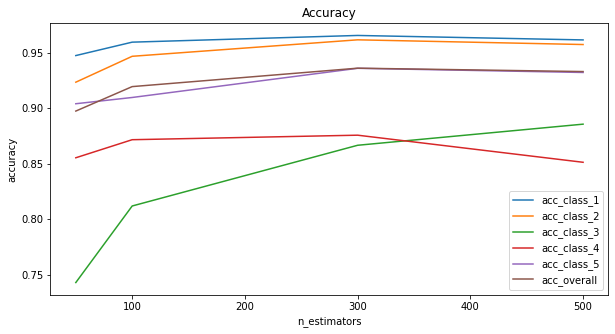

In [76]:

data

{'acc_class_1': array([0.94758065, 0.95967742, 0.96572581, 0.96169355]),
 'acc_class_2': array([0.92356688, 0.94692144, 0.96178344, 0.95753715]),
 'acc_class_3': array([0.74285714, 0.81190476, 0.86666667, 0.88571429]),
 'acc_class_4': array([0.85539715, 0.87169043, 0.87576375, 0.85132383]),
 'acc_class_5': array([0.90413534, 0.90977444, 0.93609023, 0.93233083]),
 'acc_overall': array([0.8975229 , 0.91957923, 0.93620631, 0.93315236])}

'class6'

In [65]:
results[:,0]

array([0.94758065, 0.95967742, 0.96572581, 0.96169355])

In [61]:
results

array([[0.94758065, 0.92356688, 0.74285714, 0.85539715, 0.90413534,
        0.8975229 ],
       [0.95967742, 0.94692144, 0.81190476, 0.87169043, 0.90977444,
        0.91957923],
       [0.96572581, 0.96178344, 0.86666667, 0.87576375, 0.93609023,
        0.93620631],
       [0.96169355, 0.95753715, 0.88571429, 0.85132383, 0.93233083,
        0.93315236]])

In [ ]:
fig = plt.figure(figsize=(8,8))
nn_mtx = metrics.confusion_matrix(y_test, y_knn)
print(nn_mtx)
font = {'weight' : 'bold', 'size'   :22}

matplotlib.rc('xtick', labelsize=20) 
matplotlib.rc('ytick', labelsize=20) 
sns.heatmap(nn_mtx, annot=True, fmt="d")
plt.ylabel("Real value")
plt.xlabel("Predicted value")

Please, write down your thoughts on the experiment results.

## Part 2. Use hyper parameter tuning system

Use [optuna](https://optuna.org/), [hyperopt](http://hyperopt.github.io/hyperopt/) or any other zero order optimizer to find optimal hyper param set.

In [ ]:
# YOUR CODE HERE

### Part 3. Interpret the model predictions
Despite you are free to use any approaches to interpret the model predictions, please use [`shap`](https://github.com/slundberg/shap) to build some plots (e.g. the ones we've seen on week02) and try to interpret them.

In [ ]:
import shap


# YOUR CODE HERE

_Your thoughts about the plots and model behaviour._